## ITP Modelling for distortion
Author: Tiantian Xian;     
Modified: 5 May 2019

### Inport libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

%matplotlib inline

### The following code read the single CSV files and Excel files and, process (analyse) the data in them

In [2]:
# Input parameters
###########################################
# Path of the input and output data files
path_input = '.\\input_data'
path_output = '.\\output_data'


# Acquire the names of the input data files (NO need to change)
#=============================================
# Acquire the full path of the current directory
cur_path = os.path.abspath('.')    

# Go to the directory which contains the input data
path_input = os.path.abspath(path_input)
os.chdir(path_input)

# Obtain the list of names of the input data files
input_files = os.listdir(path_input)
# Count the number of files (input data)
file_count = len(input_files)
#=============================================


# The file name of the excel in the ouput data directory
output_data_excel_name = 'Trail B CNM measurements.xlsx'
# The file name of the excel in the ouput data directory
cutting_condition_excel_name = 'Trail B operating conditions.xlsx'

# Specify how many lines you want to skip (excluding the column label) before reading the data
input_skip_lines = 19
output_skip_lines = 0
CC_skip_lines = 0

# Number of sheets in the output data excel file
output_number_of_sheets = 18
output_number_of_CC = 18

# Specify the name of the output excel file
output_excel_name = cur_path + '\\' + 'Finishing_EM_filtered.xlsx'

# Specify the colume labels for the data
input_col_list = ['time (s)', 'Fx (N)', 'Fy (N)', 'Fz (N)']
# Specify the colume labels for the data
output_col_list = ['time (s)', 'Fx (N)', 'Fy (N)', 'Fz (N)', 'Abs Geo Mean (N)']
# Specify the index of the final data (after processing)
final_data_index = ['Fx_min', 'Fx_max', 'Fx_avg', 'Fy_min', 'Fy_max', 'Fy_avg', 'Fz_min', 'Fz_max', 'Fz_avg',\
                    'xyz_min', 'xyz_max', 'xyz_avg']

# Low-pass filter parameters 
order = 3    # order of the smooth function (polynomial)
fs = 15000.0   # original sample frequency, Hz
cutoff = 10.0   # desired frequency of the filter, Hz
###########################################



# Define the filter function
#=================================================================
def lowpass_filter(data, cutoff, fs, order=order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
#=================================================================
    

    

# Read and process the input data
#==================================================================================================

# Initialisation
#=================================================================
i = 0
# Initialise an array to store the processed data
processed_data = {}
# Create a Pandas Excel writer using XlsxWriter as the engine.
output_excel = pd.ExcelWriter(output_excel_name, engine='xlsxwriter')

name_list = []
#================================================================= 



# Loop over all the input data files and perform calculations
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for name in input_files:
    # Read the data from the csv file
    sample1 = pd.read_csv(name, header=input_skip_lines)
    # Asign the colume labels for the data
    sample1.columns = input_col_list  
    
    # Define the title of the result figures
    result_figure_title1 = 'figure--' + name + '.png'
    
    name_list = np.append(name_list, name)


    # Filter the data
    #=================================================================
    # Define the data to be filtered
    t = sample1.loc[:,'time (s)']
    data1 = sample1.loc[:,'Fx (N)']
    data2 = sample1.loc[:,'Fy (N)']
    data3 = sample1.loc[:,'Fz (N)']
    
    # Filter the data using low-pass filter
    y1 = abs(lowpass_filter(data1, cutoff, fs, order))
    y2 = abs(lowpass_filter(data2, cutoff, fs, order))
    y3 = abs(lowpass_filter(data3, cutoff, fs, order))
    
    # Calculate the geometric mean of Fx, Fy and Fz
    xyz = np.sqrt(y1**2 + y2**2 + y3**2)
    #=================================================================


    
    # Analyse the data
    #=================================================================
    Fx_min = y1.min()
    Fx_max = y1.max()
    Fx_avg = np.mean(y1)
    Fy_min = y2.min()
    Fy_max = y2.max()
    Fy_avg = np.mean(y2)
    Fz_min = y3.min()
    Fz_max = y3.max()
    Fz_avg = np.mean(y3)
    xyz_min = xyz.min()
    xyz_max = xyz.max()
    xyz_avg = np.mean(xyz)
    
    processed_data[i] = np.vstack((Fx_min, Fx_max, Fx_avg, Fy_min, Fy_max, Fy_avg, Fz_min, Fz_max, Fz_avg,\
                                   xyz_min, xyz_max, xyz_avg))
    #=================================================================
    
    
    
#     # Write the results out to Excel sheets
#     #=================================================================
#     # Stack the individual arrays into one array
#     temp = np.vstack((t.T, y1.T, y2.T, y3.T, xyz.T))
    
#     # Convert the array into Pandas DataFrame
#     filtered_data = pd.DataFrame(data=temp.T, columns=output_col_list)
    
#     # Write the dataframe to an XlsxWriter Excel object.
#     filtered_data.to_excel(output_excel, sheet_name=name)
#     #================================================================



#     # Plot both the original and filtered signals
#     #================================================================
#     # Set the overall size of the figure
#     plt.figure(figsize=(24,30))
#     # Set the font size of the output figure
#     plt.rcParams.update({'font.size': 24})

#     plt.subplot(4, 1, 1)
#     plt.plot(t, data1, 'b-', label='Fx (N)')
#     plt.plot(t, y1, 'r-', linewidth=2, label='Fx filtered (N)')
#     plt.xlabel('Time (s)')
#     #plt.grid()
#     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

#     plt.subplot(4, 1, 2)
#     plt.plot(t, data2, 'b-', label='Fy (N)')
#     plt.plot(t, y2, 'r-', linewidth=2, label='Fy filtered (N)')
#     plt.xlabel('Time (s)')
#     #plt.grid()
#     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

#     plt.subplot(4, 1, 3)
#     plt.plot(t, data3, 'b-', label='Fz (N)')
#     plt.plot(t, y3, 'r-', linewidth=2, label='Fz filtered (N)')
#     plt.xlabel('Time (s)')
#     #plt.grid()
#     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

#     plt.subplot(4, 1, 4)
#     plt.plot(t, y1, 'b-', linewidth=2, label='Fx filtered (N)')
#     plt.plot(t, y2, 'r-', linewidth=2, label='Fy filtered (N)')
#     plt.plot(t, y3, 'm-', linewidth=2, label='Fz filtered (N)')
#     plt.plot(t, xyz, 'g-', linewidth=2, label='Abs Geo Mean (N)')
#     plt.xlabel('Time (s)')
#     #plt.grid()
#     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

#     plt.subplots_adjust(hspace=0.35, right=0.7)
#     #plt.show()

#     plt.savefig(cur_path + '\\' + result_figure_title1, dpi=100)
    
    i = i + 1
    #================================================================
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


    
if (file_count > 1):
    temp = np.hstack((processed_data[0], processed_data[1]))
    for i in range(file_count):
        if (i <= 1):
            continue
        temp = np.hstack((temp, processed_data[i]))
else:
    temp = processed_data[0]

# Convert the array into Pandas DataFrame
final_data = pd.DataFrame(data=temp, columns=name_list, index=final_data_index)

# Write the processed final data to Excel
final_data.to_excel(output_excel, sheet_name='processed_results')

# Close the Pandas Excel writer and output the Excel file.
output_excel.save()    
    
# Return to the upper (original) directory        
os.chdir('..')    



# Read the cutting conditions (abbrevation: CC)

CC_data = pd.read_excel(cutting_condition_excel_name, header=CC_skip_lines)



#==================================================================================================





# Read and process the output data
#==================================================================================================
os.chdir(path_output)


# Initialisation
#=================================================================
# Read the excel file
excel_file = pd.ExcelFile(output_data_excel_name)
# Get the name of all the sheets in the excel file
sheet_names = excel_file.sheet_names

# Initialise the array to store the information of the sheets
sheets = {}
# Initialise an array to store the processed data
processed_data = {}
# Create a Pandas Excel writer using XlsxWriter as the engine.
#output_excel = pd.ExcelWriter(output_excel_name, engine='xlsxwriter')
#=================================================================    

data_output1 = []
data_output2 = []

# Loop over all the sheets and perform calculations
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i in range(output_number_of_sheets):
    # Read the data of the sheet from the excel file
    sheets[i] = pd.read_excel(output_data_excel_name, sheet_name=sheet_names[i], header=output_skip_lines)
    
    # Calculate the absolute values of the "difference" column
    absolute_values = abs(sheets[i].loc[:,'Difference'])
    
    # Find the maximum value of the "difference" column and put them together in a vector
    data_output1 = np.append(data_output1, absolute_values.max())
    data_output2 = np.append(data_output2, absolute_values.mean())
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

data_output = np.vstack((data_output1, data_output2))
data_output = data_output.T

# Convert the array into Pandas DataFrame
data_output = pd.DataFrame(data=data_output, index=name_list, columns=['Max distortion (mm)', 'Mean distortion (mm)'])

# Return to the upper (original) directory 
os.chdir('..')    
#==================================================================================================


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [131]:
os.chdir('..') 

### The following code tests the extrapolation capability of the ANN using leave-one-out cross validation (multiple output)


mean absolute error for max distortion is 0.019, mean distortion is 0.013
mean relative error for max distortion is 0.650, mean distortion is 0.943
mean square root error for max distortion is 0.259, mean distortion is 0.471
R2 for max distortion is 0.622, mean distortion is 0.563


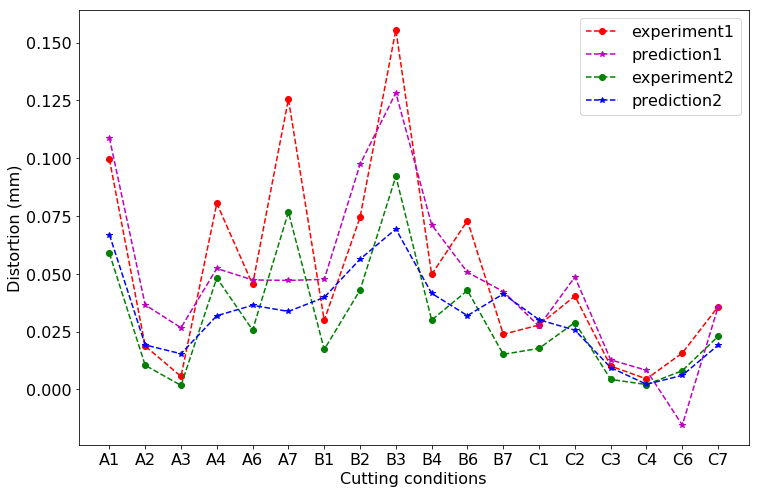

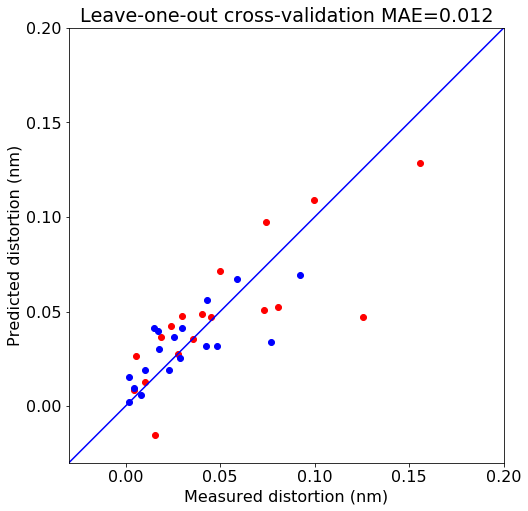

In [16]:
##########################################
choice1 = 4
choice2 = 7
hidden_layer_sizes = 10
Figure_name0 = 'Max_min_avg_force_only_ABC'
##########################################

figure_name1 = Figure_name0 + '--Result_1'
figure_name2 = Figure_name0 + '--Result_2'
figure_name3 = Figure_name0 + '--Result_3'


if choice1 == 1:
    X = final_data.iloc[0:9,0:6]
    y = data_output.iloc[0:6,0:2]
elif choice1 == 2:
    X = final_data.iloc[0:9,6:12]
    y = data_output.iloc[6:12,0:2]    
elif choice1 == 3:
    X = final_data.iloc[0:9,12:18]
    y = data_output.iloc[12:18,0:2]   
else:
    X = final_data.iloc[0:9,0:18]
    y = data_output.iloc[0:18,0:2]


if choice2 == 1:   # only take the maximum values as the input
    X = X.drop(index=['Fx_min', 'Fx_avg', 'Fy_min', 'Fy_avg', 'Fz_min', 'Fz_avg'])
elif choice2 == 2:    # only take the average values as the input
    X = X.drop(index=['Fx_min', 'Fx_max', 'Fy_min', 'Fy_max', 'Fz_min', 'Fz_max'])
elif choice2 == 3:    # only take the average values as the input
    X = X.drop(index=['Fx_avg', 'Fx_max', 'Fy_avg', 'Fy_max', 'Fz_avg', 'Fz_max'])
elif choice2 == 4:    # only take the average values as the input
    X = X.drop(index=['Fx_min', 'Fy_min', 'Fz_min'])
elif choice2 == 5:    # only take the average values as the input
    X = X.drop(index=['Fx_max', 'Fy_max', 'Fz_max'])
elif choice2 == 6:    # only take the average values as the input
    X = X.drop(index=['Fx_avg', 'Fy_avg', 'Fz_avg'])


X = X.T


# Normalise all the input and output data 
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

# Initialise the leave-one-out cross validation function parameters
loo = LeaveOneOut()
loo.get_n_splits(X)

# choose the parameters for the neural network (using hyperbolic tangent activation function)
reg = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes), activation='tanh', solver='lbfgs', alpha=1e-5,\
                   learning_rate_init=1e-3, max_iter=10000000, random_state=1, tol=1e-15)
    
    
y_pred_all_1 = []
y_test_all_1 = []
y_pred_all_2 = []
y_test_all_2 = []
all_pred_1 = []
all_pred_2 = []
counter = 0

LeaveOneOut()
for train_index, test_index in loo.split(X):
    counter = counter + 1
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]   
    
    # train the neural network by fitting the calculated output to the desired output
    reg.fit(X_train, y_train)
    
    # test the trained neural network using test set
    y_pred = reg.predict(X_test)
    
    if counter == 1:
        y_pred_all = y_pred
        y_test_all = y_test
    else:
        y_pred_all = np.vstack((y_pred_all, y_pred))
        y_test_all = np.vstack((y_test_all, y_test))
#     y_test_all_1 = np.append(y_test_all_1, y_test[0,0])
#     y_pred_all_1 = np.append(y_pred_all_1, y_pred[0,0])
#     y_test_all_2 = np.append(y_test_all_2, y_test[0,1])
#     y_pred_all_2 = np.append(y_pred_all_2, y_pred[0,1])
    
    
#     # calculate the prediction values for all data using the trained ANN parameters
#     temp_pred = reg.predict(X_scaled)
    
#     if counter == 1:
#         all_pred_1 = temp_pred
#     else:
#         all_pred_1 = np.vstack((all_pred_1, temp_pred))
    
    # print score and loss of the training
    #print("Training set score: %f" % reg.score(X_train, y_train))
    #print("Training set loss: %f" % reg.loss_)
    #print(" ")
    

# Denormalise all the input and output data 
y_test_all = y_scaler.inverse_transform(y_test_all)
y_pred_all = y_scaler.inverse_transform(y_pred_all)


y_test_all_1 = y_test_all[:,0]
y_pred_all_1 = y_pred_all[:,0]
y_test_all_2 = y_test_all[:,1]
y_pred_all_2 = y_pred_all[:,1]


# all_pred = y_scaler.inverse_transform(all_pred)
# all_pred_avg = np.mean(all_pred, axis = 0)
# 
# all_pred_err = np.zeros(all_pred.shape[1])
# for i in range(all_pred.shape[1]):
#     all_pred_err[i] = np.sqrt(np.dot((all_pred[i,:] - all_pred_avg[i]).T,(all_pred[i,:] - all_pred_avg[i])))/all_pred.shape[1]


err_absolute_1 = abs(y_test_all_1 - y_pred_all_1).sum()/y_test_all_1.shape[0]
err_relative_1 = (abs((y_test_all_1 - y_pred_all_1)/y_test_all_1)).sum()/y_test_all_1.shape[0]
err_squreroot_1 = np.sqrt(np.dot(((y_test_all_1 - y_pred_all_1)/y_test_all_1).T, ((y_test_all_1 - y_pred_all_1)/y_test_all_1)))/y_test_all_1.shape[0]
err_absolute_2 = abs(y_test_all_2 - y_pred_all_2).sum()/y_test_all_2.shape[0]
err_relative_2 = (abs((y_test_all_2 - y_pred_all_2)/y_test_all_2)).sum()/y_test_all_2.shape[0]
err_squreroot_2 = np.sqrt(np.dot(((y_test_all_2 - y_pred_all_2)/y_test_all_2).T, ((y_test_all_2 - y_pred_all_2)/y_test_all_2)))/y_test_all_2.shape[0]

print("mean absolute error for max distortion is {0:5.3f}, mean distortion is {1:5.3f}".format(err_absolute_1, err_absolute_2))
print("mean relative error for max distortion is {0:5.3f}, mean distortion is {1:5.3f}".format(err_relative_1,err_relative_2))
print("mean square root error for max distortion is {0:5.3f}, mean distortion is {1:5.3f}".format(err_squreroot_1, err_squreroot_2))

residuals_1 = y_test_all_1 - y_pred_all_1
ss_res_1 = np.sum(residuals_1**2)
ss_tot_1 = np.sum((y_test_all_1-np.mean(y_test_all_1))**2)
r_squared_1 = 1 - (ss_res_1 / ss_tot_1)
residuals_2 = y_test_all_2 - y_pred_all_2
ss_res_2 = np.sum(residuals_2**2)
ss_tot_2 = np.sum((y_test_all_2-np.mean(y_test_all_2))**2)
r_squared_2 = 1 - (ss_res_2 / ss_tot_2)
print("R2 for max distortion is {0:5.3f}, mean distortion is {1:5.3f}".format(r_squared_1, r_squared_2))



# Set the overall size of the figure
plt.figure(figsize=(12,8))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

ind = np.arange(y_test_all.shape[0])    # the x locations for the groups

plt.plot(ind,y_test_all_1,'ro--',label='experiment1')
plt.plot(ind,y_pred_all_1,'m*--',label='prediction1')
plt.plot(ind,y_test_all_2,'go--',label='experiment2')
plt.plot(ind,y_pred_all_2,'b*--',label='prediction2')
plt.xticks(ind,['A1','A2','A3','A4','A6','A7','B1','B2','B3','B4','B6','B7','C1','C2','C3','C4','C6','C7'])
plt.xlabel('Cutting conditions')
plt.ylabel('Distortion (mm)')
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right')
#plt.grid()
plt.legend()
plt.savefig(figure_name1, dpi=100)
plt.show()




# Set the overall size of the figure
plt.figure(figsize=(12,8))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

ind = np.arange(y_test_all.shape[0])    # the x locations for the groups

plt.plot(y_test_all_1, y_pred_all_1, 'ro')
plt.plot(y_test_all_2, y_pred_all_2, 'bo')
# plt.errorbar(y, y_pred_all, yerr=all_pred_err, fmt='ro', capsize=4 )
plt.plot([-0.03,0.20],[-0.03,0.20],'b-')
#plt.xticks(ind,['A1','A2','A3','A4','A6','A7','B1','B2','B3','B4','B6','B7','C1','C2','C3','C4','C6','C7'])
plt.xlabel('Measured distortion (nm)')
plt.ylabel('Predicted distortion (nm)')
plt.title('Leave-one-out cross-validation MAE=0.012')
plt.xlim((-0.03,0.20))
plt.ylim((-0.03,0.20))
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right')
#plt.grid()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(figure_name2, dpi=100)
plt.show()

In [17]:
y


,Max distortion (mm),Mean distortion (mm)
A1_Finishing_EM.csv,0.09959,0.058889
A2_Finishing_EM.csv,0.01873,0.010402
A3_Finishing_EM.csv,0.00560,0.001718
A4_Finishing_EM.csv,0.08047,0.048211
A6_Finishing_EM.csv,0.04540,0.025649
A7_Finishing_EM.csv,0.12557,0.076707
B1_Finishing_EM.csv,0.02986,0.017254
B2_Finishing_EM.csv,0.07440,0.042917
B3_Finishing_EM.csv,0.15562,0.092173
B4_Finishing_EM.csv,0.04971,0.029982


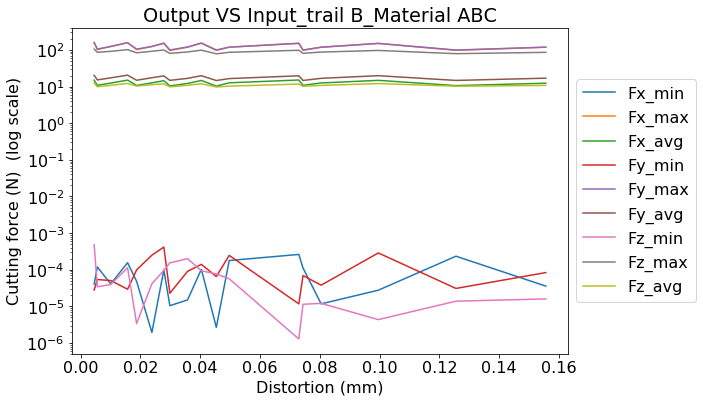

In [18]:
# Set the overall size of the figure
plt.figure(figsize=(12,6))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

y1 = y.iloc[:,0]
y1 = np.sort(y1)
xyz = final_data.iloc[10,0:6]

plt.plot(y1,X.iloc[:,0],label='Fx_min')
plt.plot(y1,X.iloc[:,1],label='Fx_max')
plt.plot(y1,X.iloc[:,2],label='Fx_avg')
plt.plot(y1,X.iloc[:,3],label='Fy_min')
plt.plot(y1,X.iloc[:,4],label='Fy_max')
plt.plot(y1,X.iloc[:,5],label='Fy_avg')
plt.plot(y1,X.iloc[:,6],label='Fz_min')
plt.plot(y1,X.iloc[:,7],label='Fz_max')
plt.plot(y1,X.iloc[:,8],label='Fz_avg')


plt.xlabel('Distortion (mm)')
plt.ylabel('Cutting force (N)  (log scale)')
plt.title('Output VS Input_trail B_Material ABC')
plt.yscale('log')
plt.subplots_adjust(hspace=0.35, right=0.7)
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
# plt.legend()

plt.savefig(figure_name3, dpi=100)
plt.show()

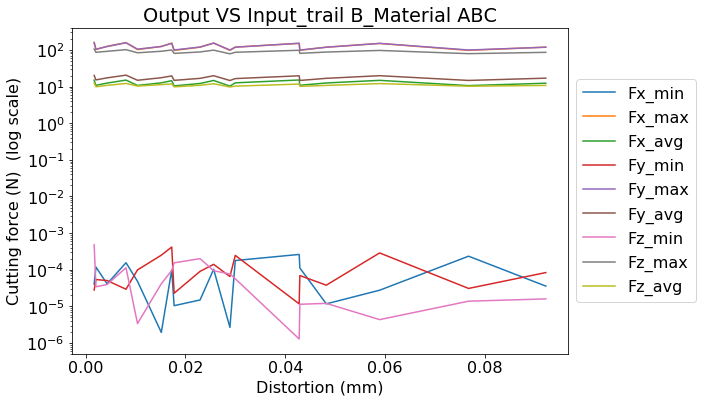

In [19]:
# Set the overall size of the figure
plt.figure(figsize=(12,6))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

y2 = y.iloc[:,1]
y2 = np.sort(y2)
xyz = final_data.iloc[10,0:6]

plt.plot(y2,X.iloc[:,0],label='Fx_min')
plt.plot(y2,X.iloc[:,1],label='Fx_max')
plt.plot(y2,X.iloc[:,2],label='Fx_avg')
plt.plot(y2,X.iloc[:,3],label='Fy_min')
plt.plot(y2,X.iloc[:,4],label='Fy_max')
plt.plot(y2,X.iloc[:,5],label='Fy_avg')
plt.plot(y2,X.iloc[:,6],label='Fz_min')
plt.plot(y2,X.iloc[:,7],label='Fz_max')
plt.plot(y2,X.iloc[:,8],label='Fz_avg')


plt.xlabel('Distortion (mm)')
plt.ylabel('Cutting force (N)  (log scale)')
plt.title('Output VS Input_trail B_Material ABC')
plt.yscale('log')
plt.subplots_adjust(hspace=0.35, right=0.7)
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
# plt.legend()

plt.savefig(figure_name3, dpi=100)
plt.show()

In [9]:
y_test

array([[1.17248924, 1.14253996]])

In [12]:
y_test[0,1]

1.1425399634066034

In [17]:
X

,Fx_min,Fx_max,Fx_avg,Fy_min,Fy_max,Fy_avg,Fz_min,Fz_max,Fz_avg
A1_Finishing_EM.csv,0.000041,159.835986,14.978665,0.000028,158.694269,20.253029,0.000480,105.494784,12.538842
A2_Finishing_EM.csv,0.000119,102.617908,10.804738,0.000054,104.945654,15.213782,0.000034,86.108985,9.875598
A3_Finishing_EM.csv,0.000041,125.309960,12.442078,0.000051,123.796422,17.284549,0.000040,91.540981,10.786237
A4_Finishing_EM.csv,0.000156,157.998695,15.022744,0.000029,156.968640,20.503899,0.000113,101.847997,12.172597
A6_Finishing_EM.csv,0.000048,101.810781,10.739246,0.000099,105.157015,14.850146,0.000003,83.521926,10.328444
A7_Finishing_EM.csv,0.000002,124.543829,12.627959,0.000250,124.015135,17.437161,0.000041,91.983232,11.291722
B1_Finishing_EM.csv,0.000099,152.063265,14.467307,0.000416,152.652765,19.556211,0.000096,99.578219,11.837982
B2_Finishing_EM.csv,0.000010,96.783198,10.430740,0.000023,99.682999,14.767694,0.000154,80.461500,9.818555
B3_Finishing_EM.csv,0.000015,119.087765,12.136482,0.000090,119.797617,16.752814,0.000201,88.050382,10.843248
B4_Finishing_EM.csv,0.000103,153.545486,14.671945,0.000140,153.817714,19.792578,0.000094,98.614848,11.925646


In [73]:
X

array([[4.05423159e-05, 1.59835986e+02, 1.49786653e+01, 2.79298451e-05,
        1.58694269e+02, 2.02530285e+01, 4.79612745e-04, 1.05494784e+02,
        1.25388418e+01],
       [1.18676707e-04, 1.02617908e+02, 1.08047377e+01, 5.40242275e-05,
        1.04945654e+02, 1.52137817e+01, 3.43028727e-05, 8.61089851e+01,
        9.87559819e+00],
       [4.11907750e-05, 1.25309960e+02, 1.24420776e+01, 5.07436289e-05,
        1.23796422e+02, 1.72845490e+01, 3.96350148e-05, 9.15409814e+01,
        1.07862372e+01],
       [1.55535486e-04, 1.57998695e+02, 1.50227442e+01, 2.94191690e-05,
        1.56968640e+02, 2.05038993e+01, 1.13370304e-04, 1.01847997e+02,
        1.21725972e+01],
       [4.84099110e-05, 1.01810781e+02, 1.07392464e+01, 9.90327116e-05,
        1.05157015e+02, 1.48501455e+01, 3.39602489e-06, 8.35219263e+01,
        1.03284442e+01],
       [1.94770818e-06, 1.24543829e+02, 1.26279591e+01, 2.49675423e-04,
        1.24015135e+02, 1.74371612e+01, 4.14212796e-05, 9.19832319e+01,
        1.1

### The following code tests the fitting accuracy of the ANN

err is 0.000
R2 is 1.000


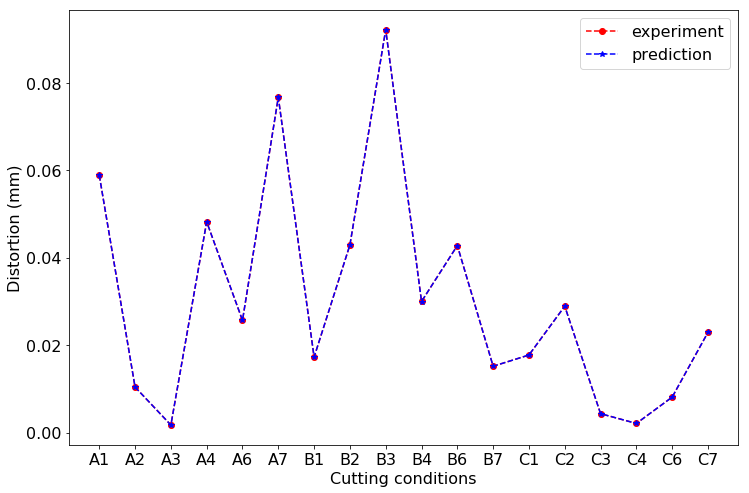

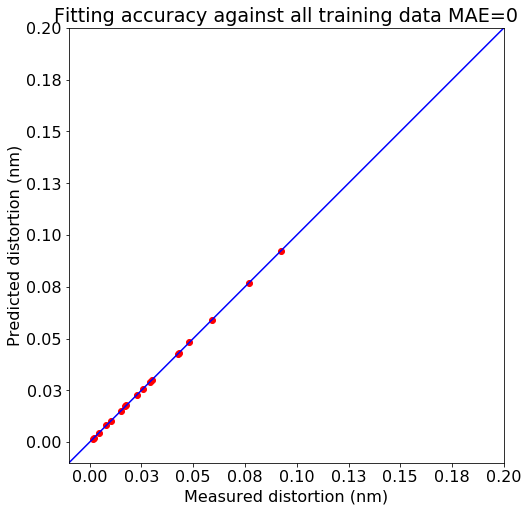

In [127]:
##########################################
choice1 = 4
choice2 = 7
hidden_layer_sizes = 10
Figure_name0 = 'Max_force_only_ABC'
##########################################

figure_name1 = Figure_name0 + '--Result_1'
figure_name2 = Figure_name0 + '--Result_2'
figure_name3 = Figure_name0 + '--Result_3'


if choice1 == 1:
    X = final_data.iloc[0:9,0:6]
    y = data_output.iloc[0:6,0]
elif choice1 == 2:
    X = final_data.iloc[0:9,6:12]
    y = data_output.iloc[6:12,0]    
elif choice1 == 3:
    X = final_data.iloc[0:9,12:18]
    y = data_output.iloc[12:18,0]   
else:
    X = final_data.iloc[0:9,0:18]
    y = data_output.iloc[0:18,0]


if choice2 == 1:   # only take the maximum values as the input
    X = X.drop(index=['Fx_min', 'Fx_avg', 'Fy_min', 'Fy_avg', 'Fz_min', 'Fz_avg'])
elif choice2 == 2:    # only take the average values as the input
    X = X.drop(index=['Fx_min', 'Fx_max', 'Fy_min', 'Fy_max', 'Fz_min', 'Fz_max'])
elif choice2 == 3:    # only take the average values as the input
    X = X.drop(index=['Fx_avg', 'Fx_max', 'Fy_avg', 'Fy_max', 'Fz_avg', 'Fz_max'])
elif choice2 == 4:    # only take the average values as the input
    X = X.drop(index=['Fx_min', 'Fy_min', 'Fz_min'])
elif choice2 == 5:    # only take the average values as the input
    X = X.drop(index=['Fx_max', 'Fy_max', 'Fz_max'])
elif choice2 == 6:    # only take the average values as the input
    X = X.drop(index=['Fx_avg', 'Fy_avg', 'Fz_avg'])


X = X.T




# choose the parameters for the neural network
reg = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes), activation='tanh', solver='lbfgs', alpha=1e-5,\
                   learning_rate_init=1e-3, max_iter=10000000, random_state=1, tol=1e-15)
    
    
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y[:, None])[:, 0]

    
# train the neural network by fitting the calculated output to the desired output
reg.fit(X, y)
    
# test the trained neural network using test set
y_pred = reg.predict(X)
    

y = y_scaler.inverse_transform(y)
y_pred = y_scaler.inverse_transform(y_pred)


err = (np.sqrt(np.dot(((y - y_pred)/y).T, ((y - y_pred)/y)))).sum()/y.shape[0]
#err = (abs((y_test_all - y_pred_all)/y_test_all)).sum()/y_test_all.shape[0]
print("err is {0:5.3f}".format(err))

residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2 is {0:5.3f}".format(r_squared))



# Set the overall size of the figure
plt.figure(figsize=(12,8))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

ind = np.arange(y.shape[0])    # the x locations for the groups

plt.plot(ind,y,'ro--',label='experiment')
plt.plot(ind,y_pred,'b*--',label='prediction')
plt.xticks(ind,['A1','A2','A3','A4','A6','A7','B1','B2','B3','B4','B6','B7','C1','C2','C3','C4','C6','C7'])
plt.xlabel('Cutting conditions')
plt.ylabel('Distortion (mm)')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right')
#plt.grid()
plt.savefig('Fitting_result_2.2.1.png', dpi=100)
plt.show()




# Set the overall size of the figure
plt.figure(figsize=(12,8))
# Set the font size of the output figure
plt.rcParams.update({'font.size': 16})

ind = np.arange(y.shape[0])    # the x locations for the groups

plt.plot(y,y_pred,'ro')
plt.plot([-0.01,0.2],[-0.01,0.2],'b-')
#plt.xticks(ind,['A1','A2','A3','A4','A6','A7','B1','B2','B3','B4','B6','B7','C1','C2','C3','C4','C6','C7'])
plt.xlabel('Measured distortion (nm)')
plt.ylabel('Predicted distortion (nm)')
plt.xlim((-0.01,0.2))
plt.ylim((-0.01,0.2))
plt.title('Fitting accuracy against all training data MAE=0')
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right')
#plt.grid()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Fitting_result_2.2.2.png', dpi=100)
plt.show()